In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bert_score import score
from rouge_score import rouge_scorer

# Data preprocessing

In [11]:
original_articles = pd.read_csv('original_articles.csv', delimiter=';')
generated_articles = pd.read_csv('generated_articles.csv', delimiter=';')

Calculate bert, rouge1, rouge2, rougeL score for each article and save each value in dictionary for further use.

In [12]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
sections = ['Headline', 'Engaging Text', 'Article']

# Dictionary for scores for each article
all_scores = {section: {'bert': [], 'rouge1': [], 'rouge2': [], 'rougeL': []} for section in sections}
# Calculate and save the scores
for section in sections:
    references = original_articles[section].dropna().tolist()
    hypotheses = generated_articles[section].dropna().tolist()

    # Compute BERTScore
    P, R, F1 = score(hypotheses, references, lang="en", rescale_with_baseline=False)
    all_scores[section]['bert'] = F1.tolist()

    # Compute ROUGE scores
    rouge_scores = [scorer.score(h, r) for h, r in zip(hypotheses, references)]
    all_scores[section]['rouge1'] = [r['rouge1'].fmeasure for r in rouge_scores]
    all_scores[section]['rouge2'] = [r['rouge2'].fmeasure for r in rouge_scores]
    all_scores[section]['rougeL'] = [r['rougeL'].fmeasure for r in rouge_scores]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Mean scores for sections

In [13]:
# Calculate mean scores
results = {
    'Section': [], 'Mean BERTScore': [], 'Mean ROUGE-1': [], 'Mean ROUGE-2': [], 'Mean ROUGE-L': []
}
for section in sections:
    results['Section'].append(section)
    results['Mean BERTScore'].append(np.mean(all_scores[section]['bert']))
    results['Mean ROUGE-1'].append(np.mean(all_scores[section]['rouge1']))
    results['Mean ROUGE-2'].append(np.mean(all_scores[section]['rouge2']))
    results['Mean ROUGE-L'].append(np.mean(all_scores[section]['rougeL']))


In [14]:
results_df = pd.DataFrame(results)
results_df

,Section,Mean BERTScore,Mean ROUGE-1,Mean ROUGE-2,Mean ROUGE-L
0,Headline,0.816317,0.184100,0.059824,0.160647
1,Engaging Text,0.806170,0.144110,0.021584,0.104366
2,Article,0.849431,0.414279,0.170621,0.210120


# Calculate tag accuracy
This metric does not completely reflect the reality of correctly generated tags. For example, generated tags are missing spaces between words as well as diacritic. You can also see that sometimes it generates a synonym tags compared to the original or adds additional word into the tag. In these scenarios the tags have the same meaning, but will be evaluated as incorrect.

In [15]:
valid_rows = original_articles["Tags"].notna() & (original_articles["Tags"] != "N/A")

# Now, filter both references (original_articles) and hypotheses (generated_articles) based on valid rows
references = original_articles["Tags"][valid_rows]
hypotheses = generated_articles["Tags"][valid_rows]

correct_count = 0
total_count = 0

for ref, hyp in zip(references, hypotheses):
    # Transform references to lowercase and split by comma
    ref_tags = {tag.strip().lower() for tag in ref.split(',')}
    # Split hypotheses by space and convert to set
    hyp_tags = {tag.strip().lower() for tag in hyp.split()}

    print(f"ref: {ref_tags}\nhyp: {hyp_tags}")

    # For each tag in the hypothesis, check if it exists in the references
    for tag in hyp_tags:
        if tag in ref_tags:
            correct_count += 1
        total_count += 1

# Calculate the tag accuracy
tag_accuracy = correct_count / total_count if total_count > 0 else 0
print(f"\nTag accuracy metric: {tag_accuracy}")

ref: {'#stavebníctvo', '#infraštruktúra', '#stavebná produkcia', '#štatistický úrad'}
hyp: {'#zvýšenievýkonu', '#rok2024', '#slovenskéstavebníctvo', '#stavebnáprodukcia'}
ref: {'#pohonné látky', '#benzín', '#štatistický úrad'}
hyp: {'#zlacnenie', '#statistickyurad', '#motorovanafta', '#cenypohonnychlatok'}
ref: {'#ceny potravín', '#potraviny'}
hyp: {'#štatistiky', '#nealkoholickénápoje', '#potraviny', '#cenovéhladiny'}
ref: {'#ceny potravín', '#potraviny', '#dph', '#konsolidácia'}
hyp: {'#cenovýrozvoj', '#makroekonomika', '#inflácia', '#spotrebitelskéceny'}
ref: {'#inflácia', '#platy'}
hyp: {'#priemerna_mzda', '#inflacia', '#hospodarstvo', '#rast_mzdy'}
ref: {'#výstavba bytov', '#výstavba', '#byty', '#nájomné bývanie'}
hyp: {'#statistiky', '#slovensko', '#vystavba', '#byty'}
ref: {'#inflácia na slovensku', '#ceny potravín', '#zdražovanie'}
hyp: {'#slovensko', '#rastmiezd', '#priemernamzda', '#hospodarstvo'}
ref: {'#inflácia', '#platy'}
hyp: {'#ceny', '#makroekonomika', '#inflácia', '#s

# Plotting the score distribution of the different score types across section through histogram.

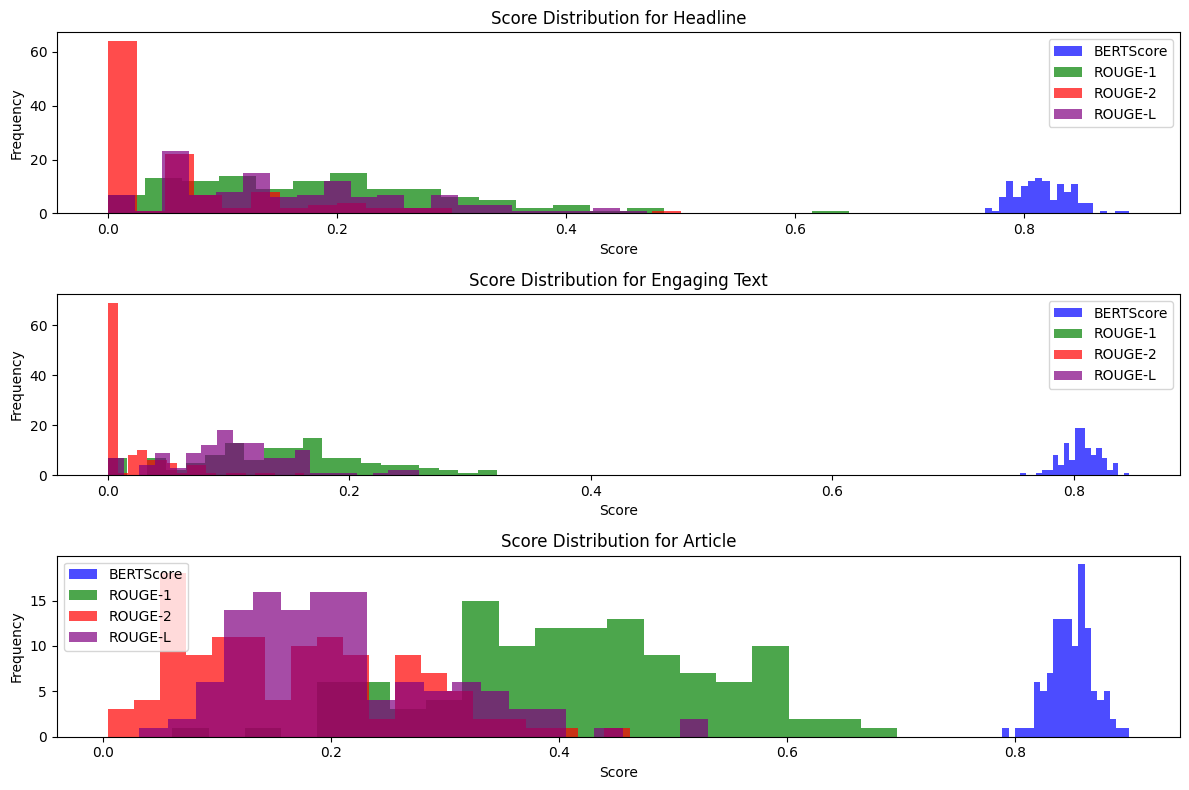

In [16]:
plt.figure(figsize=(12, 8))
for i, section in enumerate(sections):
    plt.subplot(3, 1, i+1)
    plt.hist(all_scores[section]['bert'], bins=20, alpha=0.7, label='BERTScore', color='blue')
    plt.hist(all_scores[section]['rouge1'], bins=20, alpha=0.7, label='ROUGE-1', color='green')
    plt.hist(all_scores[section]['rouge2'], bins=20, alpha=0.7, label='ROUGE-2', color='red')
    plt.hist(all_scores[section]['rougeL'], bins=20, alpha=0.7, label='ROUGE-L', color='purple')
    plt.title(f'Score Distribution for {section}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

# Boxplots of score types to showcase comparison of how well we did in different sections.

C:\Users\tomca\AppData\Local\Temp\ipykernel_17160\3581229699.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([all_scores[section][metric] for section in sections], labels=sections)
C:\Users\tomca\AppData\Local\Temp\ipykernel_17160\3581229699.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([all_scores[section][metric] for section in sections], labels=sections)
C:\Users\tomca\AppData\Local\Temp\ipykernel_17160\3581229699.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([all_scores[section][metric] for section in sections], labels=sections)
C:\Users\tomca\AppData\Local\Temp\

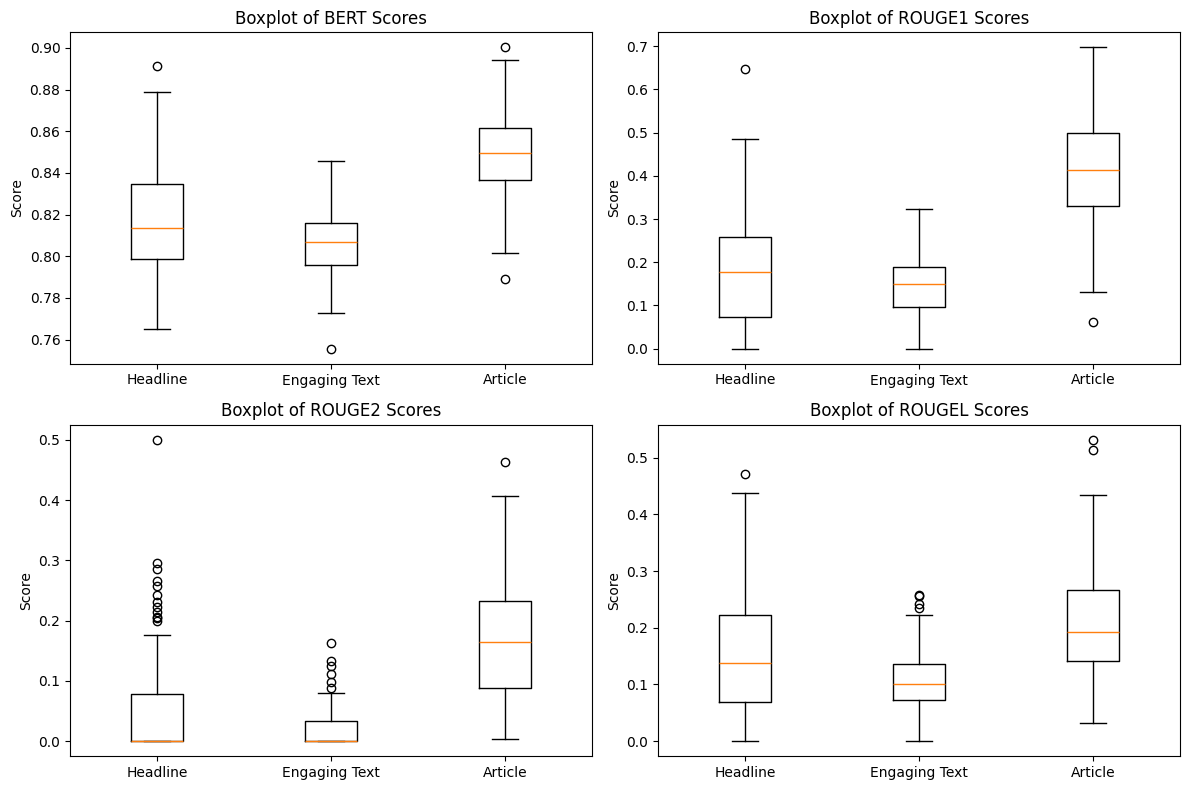

In [17]:
plt.figure(figsize=(12, 8))
for i, metric in enumerate(['bert', 'rouge1', 'rouge2', 'rougeL']):
    plt.subplot(2, 2, i+1)
    plt.boxplot([all_scores[section][metric] for section in sections], labels=sections)
    plt.title(f'Boxplot of {metric.upper()} Scores')
    plt.ylabel('Score')
plt.tight_layout()
plt.show()
